### Начало работы

In [ ]:
"Проставляем сиды, чтобы сделать результаты воспроизводимыми"

import random

import numpy as np
import torch

np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
random.seed(1)
# torch.backends.cudnn.deterministic = True #Сделать результаты воспроизводимыми

In [ ]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

### Создаю датафрейм с данными

In [ ]:
# ''' Ячейка 1: Скачиваю данные '''
# import os
# os.system(f'unzip -q -n "Infection Segmentation Data.zip"')

In [ ]:
"Если из Visual Studio"
import os
train_dir = '/home/jupyter/datasphere/project/Segmentation Tests/Infection Segmentation Data/Infection Segmentation Data/Train'
val_dir = '/home/jupyter/datasphere/project/Segmentation Tests/Infection Segmentation Data/Infection Segmentation Data/Val'
test_dir = '/home/jupyter/datasphere/project/Segmentation Tests/Infection Segmentation Data/Infection Segmentation Data/Test'

In [ ]:
import pandas as pd

In [ ]:
"Функция которая создает датафрейм с данными"

def make_df_with_path(pathdir):
    image_paths, mask_paths, infection_paths = [],[],[]
    for folder in os.listdir(pathdir):
        images = os.path.join(pathdir, folder, 'images')
        masks = os.path.join(pathdir, folder, 'lung masks')
        infections = os.path.join(pathdir, folder, 'infection masks')
        image_paths.extend([os.path.join(images, file) for file in os.listdir(images)])
        mask_paths.extend([os.path.join(masks, file) for file in os.listdir(masks)])
        infection_paths.extend([os.path.join(infections, file) for file in os.listdir(infections)])
    return pd.DataFrame({'image': image_paths, 'mask': mask_paths, 'infection': infection_paths})

train = make_df_with_path(train_dir)
val = make_df_with_path(val_dir)
test = make_df_with_path(test_dir)

In [ ]:
train

,image,mask,infection
0,/home/jupyter/datasphere/project/Segmentation ...,/home/jupyter/datasphere/project/Segmentation ...,/home/jupyter/datasphere/project/Segmentation ...
1,/home/jupyter/datasphere/project/Segmentation ...,/home/jupyter/datasphere/project/Segmentation ...,/home/jupyter/datasphere/project/Segmentation ...
2,/home/jupyter/datasphere/project/Segmentation ...,/home/jupyter/datasphere/project/Segmentation ...,/home/jupyter/datasphere/project/Segmentation ...
3,/home/jupyter/datasphere/project/Segmentation ...,/home/jupyter/datasphere/project/Segmentation ...,/home/jupyter/datasphere/project/Segmentation ...
4,/home/jupyter/datasphere/project/Segmentation ...,/home/jupyter/datasphere/project/Segmentation ...,/home/jupyter/datasphere/project/Segmentation ...
...,...,...,...
3723,/home/jupyter/datasphere/project/Segmentation ...,/home/jupyter/datasphere/project/Segmentation ...,/home/jupyter/datasphere/project/Segmentation ...
3724,/home/jupyter/datasphere/project/Segmentation ...,/home/jupyter/datasphere/project/Segmentation ...,/home/jupyter/datasphere/project/Segmentation ...
3725,/home/jupyter/datasphere/project/Segmentation ...,/home/jupyter/datasphere/project/Segmentation ...,/home/jupyter/datasphere/project/Segmentation ...
3726,/home/jupyter/datasphere/project/Segmentation ...,/home/jupyter/datasphere/project/Segmentation ...,/home/jupyter/datasphere/project/Segmentation ...


### DataLoader

In [ ]:
from PIL import Image
from torch.utils.data import Dataset

In [ ]:
"Создание класса для набора данных, вариант изображение + инфекция"
class InfectionData(Dataset):
    def __init__(self, df, transform = None, augmentation = None):
        self.df = df
        self.transform = transform
        self.augmentation = augmentation
        self.image = df['image'].tolist()
        self.infection = df['infection'].tolist()
    def __len__(self):
        return len(self.image)
    def __getitem__(self, idx):
        image_path = self.image[idx]
        infection_path = self.infection[idx]
        if not os.path.exists(image_path) or not os.path.exists(infection_path):
            print(f'Файл не найдет {image_path} или {infection_path}')

        image = Image.open(image_path).convert('L')
        infection = Image.open(infection_path).convert('L')

        if self.augmentation:
            image, infection = self.augmentation(image,infection)
        if self.transform:
            image, infection = self.transform(image, infection)

        return image, infection

### Transforms

In [ ]:
import torch
from torchvision import transforms

PATCH_SIZE = (256, 256)

def Transform(image, infection):
    image_transform = transforms.Compose([
        transforms.Resize(size=PATCH_SIZE, antialias=True),
        transforms.ToTensor() # Ensure ToTensor is before Normalize
    ])
    infection_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(size=PATCH_SIZE, antialias=False)
    ])
    return image_transform(image), infection_transform(infection).type(torch.int)


/usr/local/lib/python3.10/dist-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (4.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


### Augmentation

In [ ]:
# def augmentation(image, infection):
#     augmentation_transform = A.Compose([
#         A.HorizontalFlip(p=0.5),
#         A.VerticalFlip(p=0.5),
#         A.RandomRotate90(p=0.5),
#         A.Transpose(p=0.5),
#         A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25)
#         transforms.RandomAffine(
#         degrees=(-15, 15),         # Rotation
#         translate=(0.2, 0.2),      # Translation
#         scale=(0.8, 1.2),          # Scale
#         shear=(-15, 15)            # Shear
#                                 )
#         A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(0, 0), p=0.5),  # Случайные изменения яркости
#         A.MultiplicativeNoise(multiplier=(-0.08, 0.08), p=0.5),  # Изменение яркости через умножение
#         A.GammaTransform(gamma_limit=(-0.08, 0.08), p=0.5),  # Изменение гаммы

#     ])
#     return augmentation_transform(image), augmentation_transform(infection)

### Метрики

In [ ]:
"Супер полезная библиотека с моделями сегментации и лосами для торча"

try:
    import segmentation_models_pytorch as smp
except ImportError:
    %pip install -q segmentation_models_pytorch
    import segmentation_models_pytorch as smp

In [ ]:
"BCE_DICE с регуляризацией"

import torch
import torch.nn as nn
import torch.nn.functional as F

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True, lambda_l2=0.01):
        super(DiceBCELoss, self).__init__()
        self.lambda_l2 = lambda_l2  # Коэффициент регуляризации

    def forward(self, inputs, targets, model, smooth=1):
        # Применение сигмоиды
        inputs = torch.sigmoid(inputs)

        # Сглаживание массивов
        inputs_flat = inputs.view(-1)
        targets_flat = targets.view(-1)

        # Вычисление пересечения
        intersection = (inputs_flat * targets_flat).sum()
        dice_loss = 1 - (2. * intersection + smooth) / (inputs_flat.sum() + targets_flat.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs_flat, targets_flat, reduction='mean')

        # Суммирование Binary Cross-Entropy и Dice Loss
        Dice_BCE = BCE + dice_loss

        # Вычисление L2 регуляризации
        l2_reg = sum(p.pow(2.0).sum() for p in model.parameters())
        Dice_BCE_reg = Dice_BCE + self.lambda_l2 * l2_reg

        return Dice_BCE_reg

# Использование
lambda_l2 = 0.01  # Задание коэффициента регуляризации
BCE_Dice = DiceBCELoss(lambda_l2=lambda_l2)

In [ ]:
"BCE_DICE без регуляризации"
#PyTorch
import torch.nn as nn
import torch.nn.functional as F
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE
BCE_Dice = DiceBCELoss()


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

#PyTorch
ALPHA = 0.7
BETA = 0.3
GAMMA = 1.3

class FocalTverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalTverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, beta=BETA, gamma=GAMMA):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()

        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)
        FocalTversky = (1 - Tversky)**gamma

        return FocalTversky
FocalTversky = FocalTverskyLoss()

In [ ]:
"Определяю метрики и лосс"

JaccardLoss = smp.losses.JaccardLoss(mode='multilabel')
DiceLoss    = smp.losses.DiceLoss(mode='multilabel')
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
LovaszLoss  = smp.losses.LovaszLoss(mode='multilabel', per_image=False)
TverskyLoss = smp.losses.TverskyLoss(alpha=0.5, beta=0.7, mode='multilabel', log_loss=False)

def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

def criterion(y_pred, y_true):
    return TverskyLoss(y_pred, y_true)

### Создание Train, Val, Test наборов

In [ ]:
"Проверь количество ядер, чтобы выставить оптимальный num_workers"

import psutil

# Количество ядер процессора
cpu_cores = psutil.cpu_count(logical=False)
print(f"Количество физических ядер процессора: {cpu_cores}")

# Общий объем оперативной памяти
total_ram = psutil.virtual_memory().total / (1024 ** 3)  # в ГБ
print(f"Общий объем RAM: {total_ram:.2f} ГБ")


Количество физических ядер процессора: 8
Общий объем RAM: 94.30 ГБ


In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [ ]:
"Вариант изображение + инфекция"

train_dataset = InfectionData(train, transform=Transform)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE,shuffle = True, num_workers= 4)

val_dataset = InfectionData(val, transform=Transform)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE,shuffle = True, num_workers = 4)

test_dataset = InfectionData(test, transform = Transform)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE,shuffle = True, num_workers = 0)

### Нужные библиотеки

In [ ]:
"Импорт библиотек с git"

try:
    import segmentation_models_pytorch as smp
except ImportError:
    %pip install -q segmentation_models_pytorch
    import segmentation_models_pytorch as smp

try:
    import pytorch_warmup as warmup
except ImportError:
    %pip install -U pytorch_warmup -q
    import pytorch_warmup as warmup

%pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git -q
%pip install 'git+https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup' -q




[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


### Инициализация W&B и установка pkbar для отслеживания

In [ ]:
try:
    import pkbar
except ImportError:
    %pip install -q pkbar
    import pkbar

In [ ]:
try:
    import wandb
except ImportError:
    %pip install -q wandb
    import wandb

In [ ]:
"Нужно  поменять ключ"
wandb.login(key='')

/usr/local/lib/python3.10/dist-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (4.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
wandb: Currently logged in as: danilaaniva. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/jupyter/.netrc


True

### Код TorchTrainer

In [ ]:
"Модель"

from warmup_scheduler import GradualWarmupScheduler
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import ExponentialLR
from cosine_annealing_warmup import CosineAnnealingWarmupRestarts

# ResNet
# ResNeXt
# ResNeSt
# Res2Ne(X)t
# RegNet(x/y)
# GERNet
# SE-Net
# SK-ResNe(X)t
# DenseNet
# Inception
# EfficientNet

# model = smp.Unet(
#     encoder_name = 'timm-efficientnet-b4',
#     encoder_weights = 'imagenet',
#     in_channels = 1,
#     classes = 1
# )
model = smp.UnetPlusPlus(
    encoder_name="timm-efficientnet-b4",  # Choosing a supported encoder
    encoder_weights="imagenet",           # Using pre-trained weights from ImageNet
    in_channels=1,                        # Number of input channels
    classes=1                             # Number of output classes (e.g., for binary classification)
)

In [ ]:


"--------Scheduler, optimizer-----------"

LEARNING_RATE = 0.001
LR_FACTOR = 0.5
LR_PATIENCE = 2
EARLY_STOP_PATIENCE = 4

# optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999), weight_decay=0.01)
from torch.optim import RAdam
optimizer = RAdam(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999), weight_decay=0.01)


"Пробую разные learning rate schedulers"
# scheduler_warmupr = warmup.UntunedLinearWarmup(optimizer)


"Warmup + CosineAnealing"
# scheduler = CosineAnnealingWarmupRestarts(optimizer,
#                                           first_cycle_steps=10,
#                                           cycle_mult=1.0,
#                                           max_lr=0.01,
#                                           min_lr=0.000001,
#                                           warmup_steps=4,
#                                           gamma=1.0)

# "Learning Rate Warmup + ExponentialLR"
scheduler = ExponentialLR(optimizer, gamma=0.95)
# "На плато LR падает"
# # scheduler_reduce = ReduceLROnPlateau(optimizer,mode = 'min', factor=LR_FACTOR, patience=LR_PATIENCE, verbose = False)
scheduler_warmup = GradualWarmupScheduler(optimizer, multiplier=1, total_epoch=5, after_scheduler=None)




"Переменные"
early_stop_counter = 0
best_val_loss = float('inf')

In [ ]:
"Тренировка модели. Вариант №1. На вход изображение + инфекция"

def train_model(model, train_loader, val_loader, criterion, optimizer,scheduler, num_epochs, early_stop_patience,encoder_name = 'Unknown', decoder_name = 'U-NET'):
    try:
        wandb.init(project = 'Segmentation Infection New', config = {
        'learning_rate': LEARNING_RATE,
        'epochs': num_epochs,
        'batch_size':train_loader.batch_size,
        'encoder_name':encoder_name,
        'decoder_name':decoder_name})
        early_stop_counter = 0
        best_val_loss = float('inf')
        model.to(DEVICE)
        criterion.to(DEVICE)

        wandb.watch(model, criterion, log="all", log_freq=10)

        train_losses = []
        val_losses = []
        train_dice_scores_stat, train_iou_scores_stat = [], []
        val_dice_scores_stat, val_iou_scores_stat = [], []

        optimizer.zero_grad()  # Избежание предупреждения, issue #8
        optimizer.step()

        for epoch in range(1, num_epochs+1):
            model.train()
            scheduler_warmup.step()  # Exponential LR + Warmup
            if epoch == 1:
              print(f'Epoch {epoch}: Начальный Learning Rate: {optimizer.param_groups[0]["lr"]}')
            train_loss = 0.0
            dice_scores = []
            jaccard_scores = []
            kbar = pkbar.Kbar(target = len(train_loader), epoch = epoch-1, width = 20, always_stateful=False)
            for batch_index, (images, infections) in enumerate(train_loader):
                images, infections = images.to(DEVICE), infections.to(DEVICE)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, infections.float())
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

                dice = dice_coef(infections, outputs)
                jaccard = iou_coef(infections, outputs)
                dice_scores.append(dice.item())
                jaccard_scores.append(jaccard.item())

                kbar.update(batch_index, values=[("loss", loss.item()), ("dice", dice.item()), ("jaccard", jaccard.item())])



            avg_train_loss = train_loss/len(train_loader)
            avg_train_iou = sum(jaccard_scores) / len(jaccard_scores)
            avg_train_dice = sum(dice_scores) / len(dice_scores)
            train_losses.append(avg_train_loss)
            train_dice_scores_stat.append(avg_train_dice)
            train_iou_scores_stat.append(avg_train_iou)

            wandb.log({
                "epoch": epoch,
                "train_loss": avg_train_loss,
                "train_dice": avg_train_dice,
                "train_iou": avg_train_iou
            })

            model.eval()
            val_loss = 0.0
            val_dice_scores = []
            val_iou_scores = []
            with torch.no_grad():
                for images, infections in val_loader:
                    images, infections = images.to(DEVICE), infections.to(DEVICE)
                    outputs = model(images)
                    loss = criterion(outputs, infections.float())
                    val_loss += loss.item()
                    dice = dice_coef(infections, outputs)
                    iou = iou_coef(infections, outputs)
                    val_dice_scores.append(dice.item())
                    val_iou_scores.append(iou.item())
            avg_val_loss = val_loss / len(val_loader)
            avg_val_dice = sum(val_dice_scores)/len(val_dice_scores)
            avg_val_iou = sum(val_iou_scores)/len(val_iou_scores)

            val_losses.append(avg_val_loss)
            val_dice_scores_stat.append(avg_val_dice)
            val_iou_scores_stat.append(avg_val_iou)
            # scheduler.step() #Cosine Annealing
            # scheduler.step(val_loss) #ReduceLROnPlateu
            wandb.log({
                "epoch": epoch,
                "val_loss": avg_val_loss,
                "val_dice": avg_val_dice,
                "val_iou": avg_val_iou
            })


            # scheduler.step(avg_val_loss) #Обычный
            kbar.add(1, values=[("loss", avg_train_loss), ("dice", avg_train_dice), ("jaccard", avg_train_iou),
                                ("val_loss", avg_val_loss), ("val_dice", avg_val_dice), ("val_jaccard", avg_val_iou)])

            current_lr = optimizer.param_groups[0]['lr']
            print(f'Epoch {epoch}: Current Learning Rate: {current_lr}')

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save(model.state_dict(), 'best_model.pth')
                early_stop_counter = 0
            else:
                early_stop_counter+=1
            if early_stop_counter >= early_stop_patience:
                print(f'Early stop counter : {early_stop_counter}.')
                # break
        model.load_state_dict(torch.load('best_model.pth'))
    except Exception as e:
        print(f"Произошла ошибка: {e}")
    finally:
        wandb.finish()
    return (model, train_losses, val_losses, train_dice_scores_stat,train_iou_scores_stat, val_dice_scores_stat,val_iou_scores_stat)


### С ReduceLrOnPlateu

In [ ]:
"Модель"

from warmup_scheduler import GradualWarmupScheduler
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import ExponentialLR
from cosine_annealing_warmup import CosineAnnealingWarmupRestarts

# ResNet
# ResNeXt
# ResNeSt
# Res2Ne(X)t
# RegNet(x/y)
# GERNet
# SE-Net
# SK-ResNe(X)t
# DenseNet
# Inception
# EfficientNet

# model = smp.Unet(
#     encoder_name = 'timm-efficientnet-b4',
#     encoder_weights = 'imagenet',
#     in_channels = 1,
#     classes = 1
# )
# model = smp.DeepLabV3Plus(
#     encoder_name="timm-efficientnet-b4",  # Вы можете выбрать другой encoder, поддерживаемый библиотекой
#     encoder_weights="imagenet",           # Использование весов, предобученных на ImageNet
#     in_channels=1,                        # Количество входных каналов
#     classes=1                             # Количество выходных классов (например, для бинарной классификации)
# )

# # "Надо попробовать PSPNet, PAN и MAnet (Пробуй Manet, он для Tumor Segmentation)"
# model = smp.FPN(
#     encoder_name="timm-efficientnet-b4",  # Выбор энкодера, поддерживаемого библиотекой
#     encoder_weights="imagenet",           # Использование весов, предобученных на ImageNet
#     in_channels=1,                        # Количество входных каналов
#     classes=1                             # Количество выходных классов (например, для бинарной классификации)
# )

import segmentation_models_pytorch as smp

# MA-Net model initialization
model = smp.UnetPlusPlus(
    encoder_name="timm-efficientnet-b4",  # Choosing a supported encoder
    encoder_weights="imagenet",           # Using pre-trained weights from ImageNet
    in_channels=1,                        # Number of input channels
    classes=1                             # Number of output classes (e.g., for binary classification)
)

# MA-Net model initialization
# model = smp.PAN(
#     encoder_name="timm-efficientnet-b4",  # Choosing a supported encoder
#     encoder_weights="imagenet",           # Using pre-trained weights from ImageNet
#     in_channels=1,                        # Number of input channels
#     classes=1                             # Number of output classes (e.g., for binary classification)
# )


In [ ]:
%pip install git+https://github.com/LiyuanLucasLiu/RAdam.git -q


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
"--------Scheduler, optimizer-----------"
# from radam import RAdam
# from torch.optim import RAdam
LEARNING_RATE = 0.001
LR_FACTOR = 0.2
LR_PATIENCE = 4
EARLY_STOP_PATIENCE = 10

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999), weight_decay=0.01)
# from torch.optim import RAdam
# optimizer = RAdam(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999), weight_decay=0.01)


"Пробую разные learning rate schedulers"
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=LR_FACTOR, patience=LR_PATIENCE)
"Переменные"
early_stop_counter = 0
best_val_loss = float('inf')

# Segmentation Infection New
"Тренировка модели. Вариант №1. На вход изображение + инфекция"

def train_model(model, train_loader, val_loader, criterion, optimizer,scheduler, num_epochs, early_stop_patience,encoder_name = 'Unknown', decoder_name = 'U-NET'):
    wandb.init(project = 'Segmentation Infection DICEloss', config = {
    'learning_rate': LEARNING_RATE,
    'epochs': num_epochs,
    'batch_size':train_loader.batch_size,
    'encoder_name':encoder_name,
    'decoder_name':decoder_name})
    early_stop_counter = 0
    best_val_loss = float('inf')
    model.to(DEVICE)
    criterion.to(DEVICE)

    wandb.watch(model, criterion, log="all", log_freq=10)

    train_losses = []
    val_losses = []
    train_dice_scores_stat, train_iou_scores_stat = [], []
    val_dice_scores_stat, val_iou_scores_stat = [], []

    optimizer.zero_grad()  # Избежание предупреждения, issue #8
    optimizer.step()

    for epoch in range(1, num_epochs+1):
        model.train()
        # scheduler_warmup.step()  # Exponential LR + Warmup
        if epoch == 1:
          print(f'Epoch {epoch}: Начальный Learning Rate: {optimizer.param_groups[0]["lr"]}')
        train_loss = 0.0
        dice_scores = []
        jaccard_scores = []
        kbar = pkbar.Kbar(target = len(train_loader), epoch = epoch-1, width = 20, always_stateful=False)
        for batch_index, (images, infections) in enumerate(train_loader):
            images, infections = images.to(DEVICE), infections.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, infections.float())
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            dice = dice_coef(infections, outputs)
            jaccard = iou_coef(infections, outputs)
            dice_scores.append(dice.item())
            jaccard_scores.append(jaccard.item())

            kbar.update(batch_index, values=[("loss", loss.item()), ("dice", dice.item()), ("jaccard", jaccard.item())])



        avg_train_loss = train_loss/len(train_loader)
        avg_train_iou = sum(jaccard_scores) / len(jaccard_scores)
        avg_train_dice = sum(dice_scores) / len(dice_scores)
        train_losses.append(avg_train_loss)
        train_dice_scores_stat.append(avg_train_dice)
        train_iou_scores_stat.append(avg_train_iou)

        wandb.log({
            "epoch": epoch,
            "train_loss": avg_train_loss,
            "train_dice": avg_train_dice,
            "train_iou": avg_train_iou
        })

        model.eval()
        val_loss = 0.0
        val_dice_scores = []
        val_iou_scores = []
        with torch.no_grad():
            for images, infections in val_loader:
                images, infections = images.to(DEVICE), infections.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, infections.float())
                val_loss += loss.item()
                dice = dice_coef(infections, outputs)
                iou = iou_coef(infections, outputs)
                val_dice_scores.append(dice.item())
                val_iou_scores.append(iou.item())
        avg_val_loss = val_loss / len(val_loader)
        avg_val_dice = sum(val_dice_scores)/len(val_dice_scores)
        avg_val_iou = sum(val_iou_scores)/len(val_iou_scores)

        val_losses.append(avg_val_loss)
        val_dice_scores_stat.append(avg_val_dice)
        val_iou_scores_stat.append(avg_val_iou)
        # scheduler.step() #Cosine Annealing
        scheduler.step(val_loss) #ReduceLROnPlateu
        wandb.log({
            "epoch": epoch,
            "val_loss": avg_val_loss,
            "val_dice": avg_val_dice,
            "val_iou": avg_val_iou
        })


        # scheduler.step(avg_val_loss) #Обычный
        kbar.add(1, values=[("loss", avg_train_loss), ("dice", avg_train_dice), ("jaccard", avg_train_iou),
                            ("val_loss", avg_val_loss), ("val_dice", avg_val_dice), ("val_jaccard", avg_val_iou)])

        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch {epoch}: Current Learning Rate: {current_lr}')

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            early_stop_counter = 0
        else:
            early_stop_counter+=1
        if early_stop_counter >= early_stop_patience:
            print(f'Early stopping after {early_stop_patience} epochs without improvement.')
            break
    model.load_state_dict(torch.load('best_model.pth'))
    return (model, train_losses, val_losses, train_dice_scores_stat,train_iou_scores_stat, val_dice_scores_stat,val_iou_scores_stat)


### Начало тренировки

In [ ]:
import gc
gc.collect()
import torch
torch.cuda.empty_cache()

### Инициализация W&B и тренировка модели

In [ ]:
NUM_EPOCHS = 40

In [ ]:
wandb.finish()

In [ ]:
trained_model = train_model(model, train_loader, val_loader, BCE_Dice, optimizer, scheduler,NUM_EPOCHS,EARLY_STOP_PATIENCE,'EfficientNet-b7, BCE-DICE', 'UnetPlusPlus')

wandb: Tracking run with wandb version 0.17.0
wandb: Run data is saved locally in /home/jupyter/work/resources/Segmentation Tests/wandb/run-20240521_072711-hrfc4wz1
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run misunderstood-sun-9
wandb: ⭐️ View project at https://wandb.ai/danilaaniva/Segmentation%20Infection%20DICEloss
wandb: 🚀 View run at https://wandb.ai/danilaaniva/Segmentation%20Infection%20DICEloss/runs/hrfc4wz1


Epoch 1: Начальный Learning Rate: 0.001
117/117 [====================] - 70s 597ms/step - loss: 0.5054 - dice: 0.7318 - jaccard: 0.6730 - val_loss: 0.3031 - val_dice: 0.8725 - val_jaccard: 0.8142
Epoch 1: Current Learning Rate: 0.001
117/117 [====================] - 56s 481ms/step - loss: 0.2654 - dice: 0.8600 - jaccard: 0.8059 - val_loss: 0.2387 - val_dice: 0.8781 - val_jaccard: 0.8240
Epoch 2: Current Learning Rate: 0.001
117/117 [====================] - 56s 480ms/step - loss: 0.2308 - dice: 0.8734 - jaccard: 0.8220 - val_loss: 0.2420 - val_dice: 0.8797 - val_jaccard: 0.8277
Epoch 3: Current Learning Rate: 0.001
117/117 [====================] - 55s 474ms/step - loss: 0.2015 - dice: 0.8855 - jaccard: 0.8366 - val_loss: 0.2643 - val_dice: 0.8610 - val_jaccard: 0.8087
Epoch 4: Current Learning Rate: 0.001
117/117 [====================] - 56s 481ms/step - loss: 0.1973 - dice: 0.8819 - jaccard: 0.8344 - val_loss: 0.2574 - val_dice: 0.7641 - val_jaccard: 0.7114
Epoch 5: Current Learning Ra

### Тренировка с кросс-валидацией

In [ ]:
"--------Scheduler, optimizer-----------"
# from radam import RAdam
# from torch.optim import RAdam
LEARNING_RATE = 0.001
LR_FACTOR = 0.2
LR_PATIENCE = 4
EARLY_STOP_PATIENCE = 10

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999), weight_decay=0.01)
# from torch.optim import RAdam
# optimizer = RAdam(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999), weight_decay=0.01)


"Пробую разные learning rate schedulers"
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=LR_FACTOR, patience=LR_PATIENCE)
"Переменные"
early_stop_counter = 0
best_val_loss = float('inf')

# Segmentation Infection New
"Тренировка модели. Вариант №1. На вход изображение + инфекция"

def train_model(model, train_loader, val_loader, criterion, optimizer,scheduler, num_epochs, early_stop_patience,encoder_name = 'Unknown', decoder_name = 'U-NET'):
    wandb.init(project = 'Segmentation Infection DICEloss', config = {
    'learning_rate': LEARNING_RATE,
    'epochs': num_epochs,
    'batch_size':train_loader.batch_size,
    'encoder_name':encoder_name,
    'decoder_name':decoder_name})
    early_stop_counter = 0
    best_val_loss = float('inf')
    model.to(DEVICE)
    criterion.to(DEVICE)

    wandb.watch(model, criterion, log="all", log_freq=10)

    train_losses = []
    val_losses = []
    train_dice_scores_stat, train_iou_scores_stat = [], []
    val_dice_scores_stat, val_iou_scores_stat = [], []

    optimizer.zero_grad()  # Избежание предупреждения, issue #8
    optimizer.step()

    for epoch in range(1, num_epochs+1):
        model.train()
        # scheduler_warmup.step()  # Exponential LR + Warmup
        if epoch == 1:
          print(f'Epoch {epoch}: Начальный Learning Rate: {optimizer.param_groups[0]["lr"]}')
        train_loss = 0.0
        dice_scores = []
        jaccard_scores = []
        kbar = pkbar.Kbar(target = len(train_loader), epoch = epoch-1, width = 20, always_stateful=False)
        for batch_index, (images, infections) in enumerate(train_loader):
            images, infections = images.to(DEVICE), infections.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, infections.float())
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            dice = dice_coef(infections, outputs)
            jaccard = iou_coef(infections, outputs)
            dice_scores.append(dice.item())
            jaccard_scores.append(jaccard.item())

            kbar.update(batch_index, values=[("loss", loss.item()), ("dice", dice.item()), ("jaccard", jaccard.item())])



        avg_train_loss = train_loss/len(train_loader)
        avg_train_iou = sum(jaccard_scores) / len(jaccard_scores)
        avg_train_dice = sum(dice_scores) / len(dice_scores)
        train_losses.append(avg_train_loss)
        train_dice_scores_stat.append(avg_train_dice)
        train_iou_scores_stat.append(avg_train_iou)

        wandb.log({
            "epoch": epoch,
            "train_loss": avg_train_loss,
            "train_dice": avg_train_dice,
            "train_iou": avg_train_iou
        })

        model.eval()
        val_loss = 0.0
        val_dice_scores = []
        val_iou_scores = []
        with torch.no_grad():
            for images, infections in val_loader:
                images, infections = images.to(DEVICE), infections.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, infections.float())
                val_loss += loss.item()
                dice = dice_coef(infections, outputs)
                iou = iou_coef(infections, outputs)
                val_dice_scores.append(dice.item())
                val_iou_scores.append(iou.item())
        avg_val_loss = val_loss / len(val_loader)
        avg_val_dice = sum(val_dice_scores)/len(val_dice_scores)
        avg_val_iou = sum(val_iou_scores)/len(val_iou_scores)

        val_losses.append(avg_val_loss)
        val_dice_scores_stat.append(avg_val_dice)
        val_iou_scores_stat.append(avg_val_iou)
        # scheduler.step() #Cosine Annealing
        scheduler.step(val_loss) #ReduceLROnPlateu
        wandb.log({
            "epoch": epoch,
            "val_loss": avg_val_loss,
            "val_dice": avg_val_dice,
            "val_iou": avg_val_iou
        })


        # scheduler.step(avg_val_loss) #Обычный
        kbar.add(1, values=[("loss", avg_train_loss), ("dice", avg_train_dice), ("jaccard", avg_train_iou),
                            ("val_loss", avg_val_loss), ("val_dice", avg_val_dice), ("val_jaccard", avg_val_iou)])

        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch {epoch}: Current Learning Rate: {current_lr}')

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            early_stop_counter = 0
        else:
            early_stop_counter+=1
        if early_stop_counter >= early_stop_patience:
            print(f'Early stopping after {early_stop_patience} epochs without improvement.')
            break
    model.load_state_dict(torch.load('best_model.pth'))
    return (model, train_losses, val_losses, train_dice_scores_stat,train_iou_scores_stat, val_dice_scores_stat,val_iou_scores_stat)


In [ ]:
from sklearn.model_selection import KFold

def train_model_with_cv(model, full_dataset, criterion, optimizer, scheduler, num_epochs, num_splits, early_stop_patience, encoder_name='Unknown', decoder_name='U-NET'):
    kf = KFold(n_splits=num_splits, shuffle=True, random_state=42)
    all_train_losses = []
    all_val_losses = []
    all_train_dice_scores = []
    all_val_dice_scores = []
    all_train_iou_scores = []
    all_val_iou_scores = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(full_dataset)):
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
        train_loader = DataLoader(full_dataset, batch_size=BATCH_SIZE, sampler=train_subsampler, num_workers=4)
        val_loader = DataLoader(full_dataset, batch_size=BATCH_SIZE, sampler=val_subsampler, num_workers=4)

        print(f"Training fold {fold+1}/{num_splits}")
        trained_model, train_losses, val_losses, train_dice_scores, train_iou_scores, val_dice_scores, val_iou_scores = train_model(
            model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, early_stop_patience, encoder_name, decoder_name
        )
        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)
        all_train_dice_scores.append(train_dice_scores)
        all_train_iou_scores.append(train_iou_scores)
        all_val_dice_scores.append(val_dice_scores)
        all_val_iou_scores.append(val_iou_scores)

    return {
        'model': trained_model,
        'train_losses': np.mean(all_train_losses, axis=0),
        'val_losses': np.mean(all_val_losses, axis=0),
        'train_dice_scores': np.mean(all_train_dice_scores, axis=0),
        'train_iou_scores': np.mean(all_train_iou_scores, axis=0),
        'val_dice_scores': np.mean(all_val_dice_scores, axis=0),
        'val_iou_scores': np.mean(all_val_iou_scores, axis=0)
    }

In [ ]:
combined_df = pd.concat([train, val, test])


In [ ]:
"По 5 эпох на фолд"
NUM_EPOCHS = 5
NUM_SPLITS = 5  # Количество фолдов
full_dataset = InfectionData(combined_df, transform=Transform)  # Создание полного датасета

results = train_model_with_cv(model, full_dataset, BCE_Dice, optimizer, scheduler, NUM_EPOCHS, NUM_SPLITS, EARLY_STOP_PATIENCE, 'EfficientNet-b4', 'UnetPlusPlus')


Training fold 1/5
Epoch 1: Начальный Learning Rate: 0.001
146/146 [====================] - 70s 480ms/step - loss: 0.4961 - dice: 0.7615 - jaccard: 0.7034 - val_loss: 0.2851 - val_dice: 0.8700 - val_jaccard: 0.8145
Epoch 1: Current Learning Rate: 0.001
146/146 [====================] - 71s 483ms/step - loss: 0.2570 - dice: 0.8666 - jaccard: 0.8140 - val_loss: 0.2366 - val_dice: 0.8783 - val_jaccard: 0.8249
Epoch 2: Current Learning Rate: 0.001
146/146 [====================] - 70s 480ms/step - loss: 0.2255 - dice: 0.8766 - jaccard: 0.8254 - val_loss: 0.2328 - val_dice: 0.8826 - val_jaccard: 0.8298
Epoch 3: Current Learning Rate: 0.001
146/146 [====================] - 71s 486ms/step - loss: 0.1968 - dice: 0.8920 - jaccard: 0.8434 - val_loss: 0.2323 - val_dice: 0.8722 - val_jaccard: 0.8205
Epoch 4: Current Learning Rate: 0.001
146/146 [====================] - 71s 484ms/step - loss: 0.1749 - dice: 0.9024 - jaccard: 0.8554 - val_loss: 0.2238 - val_dice: 0.8705 - val_jaccard: 0.8212
Epoch 5: C

### Evaluate

In [ ]:
from torch.utils.data import DataLoader
import tqdm  # Импортируем tqdm для отображения progress bar
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    dice_scores = []
    jaccard_scores = []

    with torch.no_grad():
        # Оборачиваем итератор DataLoader в tqdm для отображения прогресса
        progress_bar = tqdm.tqdm(test_loader, total=len(test_loader), desc="Evaluating", leave=True)
        for images, masks in progress_bar:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            masks = masks.float()  # Убедимся, что маски имеют тип float

            outputs = model(images)
            loss = criterion(outputs, masks)
            test_loss += loss.item()

            # Рассчитаем метрики для каждого изображения в батче
            dice = dice_coef(masks, outputs)
            jaccard = iou_coef(masks, outputs)
            dice_scores.append(dice.item())
            jaccard_scores.append(jaccard.item())

            # Обновляем progress bar с текущими значениями потерь
            progress_bar.set_postfix(loss=loss.item(), dice=dice.item(), jaccard=jaccard.item())

    avg_test_loss = test_loss / len(test_loader)
    avg_dice = sum(dice_scores) / len(dice_scores)
    avg_jaccard = sum(jaccard_scores) / len(jaccard_scores)

    print(f"Test Loss: {avg_test_loss:.4f}, Average Dice: {avg_dice:.4f}, Average Jaccard: {avg_jaccard:.4f}")

In [ ]:
# Загрузка модели и вызов функции оценки
model.load_state_dict(torch.load('best_model.pth', map_location=DEVICE))
evaluate_model(model, test_loader, criterion)

Evaluating: 100%|██████████| 1166/1166 [03:51<00:00,  5.03it/s, dice=1, jaccard=1, loss=0]               

Test Loss: 0.0616, Average Dice: 0.9517, Average Jaccard: 0.9185


In [ ]:
plot_train, plot_val, plot_train_dice,plot_train_jaccard, plot_val_dice,plot_val_jaccard = trained_model[1],trained_model[2],trained_model[3],trained_model[4],trained_model[5],trained_model[6]

### Визуал

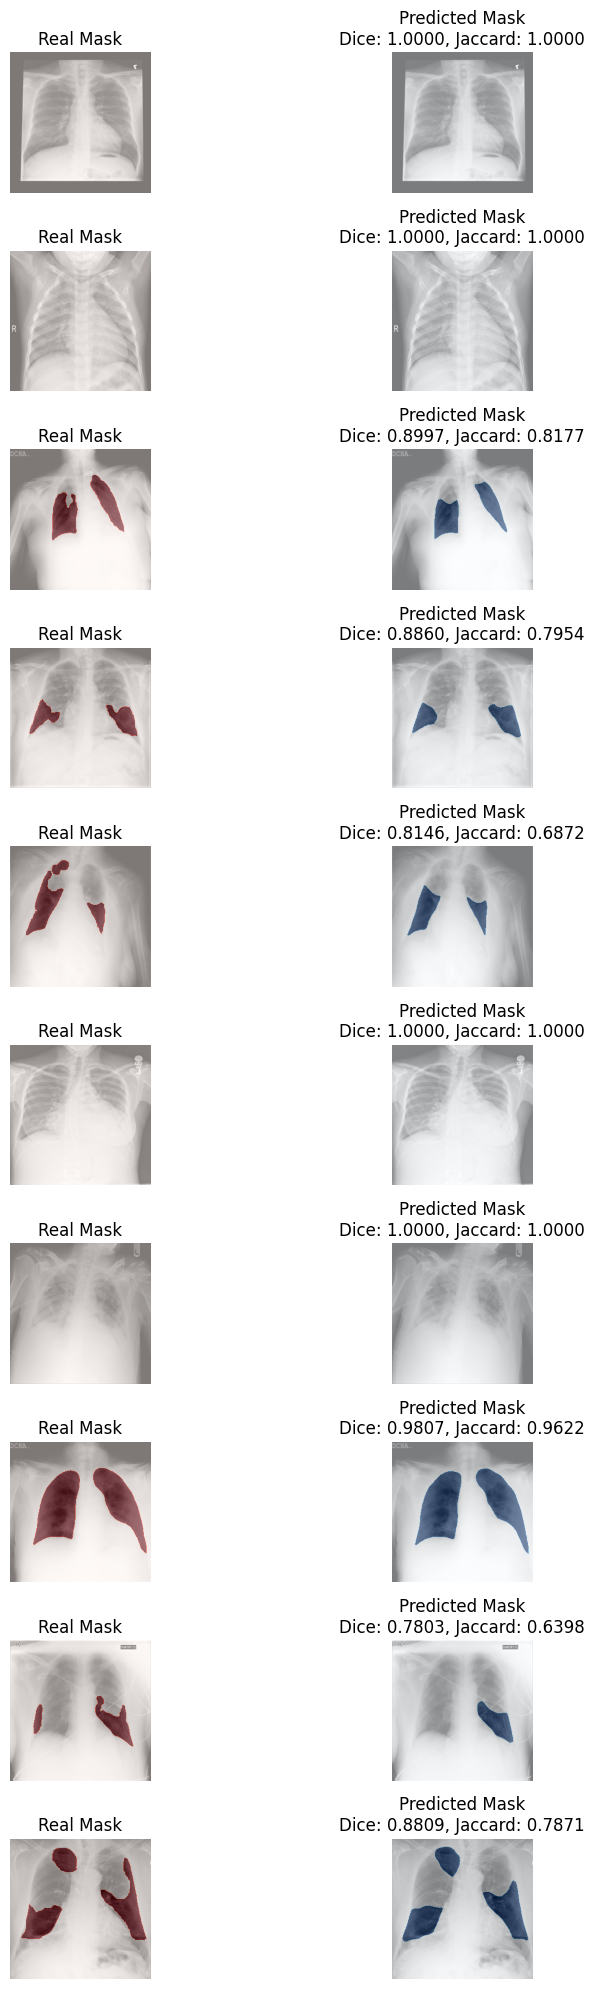

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_samples(dataset, model, device, num_samples=3):
    model.eval()
    figure, ax = plt.subplots(nrows=num_samples, ncols=2, figsize=(10, 2 * num_samples))  # Увеличил ширину для лучшего отображения

    for i in range(num_samples):
        # Случайно выбираем семпл из данных
        sample_id = np.random.randint(0, len(dataset))
        images, true_masks = dataset[sample_id]
        images = images.unsqueeze(0).to(device)  # Добавляем размерность батча и перемещаем на устройство
        true_masks = true_masks.unsqueeze(0).to(device)

        with torch.no_grad():
            pred_masks = model(images)
            pred_masks = torch.sigmoid(pred_masks)  # Применяем сигмоиду для получения вероятностей
            pred_masks = (pred_masks > 0.5).float()  # Бинаризуем предсказание

        # Считаем метрики
        dice = dice_coef(true_masks, pred_masks).item()
        jaccard = iou_coef(true_masks, pred_masks).item()

        images = images.cpu().squeeze().numpy()
        true_masks = true_masks.cpu().squeeze().numpy()
        pred_masks = pred_masks.cpu().squeeze().numpy()

        # Визуализация истинного изображения с маской
        ax[i, 0].imshow(images, cmap='gray')
        ax[i, 0].imshow(true_masks, alpha=0.5, cmap='Reds')  # Настоящая маска в красном
        ax[i, 0].set_title('Real Mask')
        ax[i, 0].axis('off')

        # Визуализация изображения с предсказанной маской
        ax[i, 1].imshow(images, cmap='gray')
        ax[i, 1].imshow(pred_masks, alpha=0.5, cmap='Blues')  # Предсказанная маска в синем
        ax[i, 1].set_title(f'Predicted Mask\nDice: {dice:.4f}, Jaccard: {jaccard:.4f}')
        ax[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Пример вызова функции
visualize_samples(test_dataset, model, DEVICE, num_samples=10)
